In [1]:
push!(LOAD_PATH, "$(pwd())/../src"); using PyPlot, StatsBase, Distributions, StochasticProcesses;

In [2]:
N(x) = cdf(Normal(), x)
d1(s, k, r, sigma, t) = (log(s/k) + (r + sigma^2/2)*t) / (sigma * sqrt(t)) 
d2(s, k, r, sigma, t) = d1(s, k, r, sigma, t) - sigma * sqrt(t)
# call
C(s, k, r, sigma, t) = N(d1(s, k, r, sigma, t))*s - N(d2(s, k, r, sigma, t))*k*exp(-r*t)
# put
P(s, k, r, sigma, t) = N(-d2(s, k, r, sigma, t))*k*exp(-r*t) - N(-d1(s, k, r, sigma, t))*s
# binary call
BC(s, k, r, sigma, t) = N(d2(s, k, r, sigma, t))*exp(-r*t)
# binary put
BP(s, k, r, sigma, t) = (1- N(d2(s, k, r, sigma, t)))*exp(-r*t)



CDelta(s, k, r, sigma, t) = N(d1(s, k, r, sigma, t))
PDelta(s, k, r, sigma, t) = CDelta(s, k, r, sigma, t) - 1

type Stock
end
price(::Stock, t, s, r, sigma) = s
payoff(::Stock, s) = s

type EuropeanCall
    strike::Float64
    expiration::Float64
end

price(c::EuropeanCall, t, s, r, sigma) = C.(s, c.strike, r, sigma, c.expiration - t)
payoff(c::EuropeanCall, s) = max(s - c.strike, 0)

type EuropeanPut
    strike::Float64
    expiration::Float64
end

price(p::EuropeanPut, t, s, r, sigma) = P.(s, p.strike, r, sigma, p.expiration - t)
payoff(c::EuropeanPut, s) = max(c.strike - s , 0)


type BinaryCall
    strike::Float64
    expiration::Float64
end

price(c::BinaryCall, t, s, r, sigma) = BC.(s, c.strike, r, sigma, c.expiration - t)
payoff(c::BinaryCall, s) = (s -> s > c.strike ? 1 : 0).(s)

type BinaryPut
    strike::Float64
    expiration::Float64
end

price(p::BinaryPut, t, s, r, sigma) = BP.(s, p.strike, r, sigma, p.expiration - t)
payoff(p::BinaryPut, s) = (s -> s < p.strike ? 1 : 0).(s)


payoff (generic function with 5 methods)

In [3]:
expectedFn(fn, process, t, k) = mean(fn.(rand(process, t, k)))

expectedFn (generic function with 1 method)

## Single Stock Portfolio

Stock expected payout is equal to current value + determenistic drift, no matter the contract length.

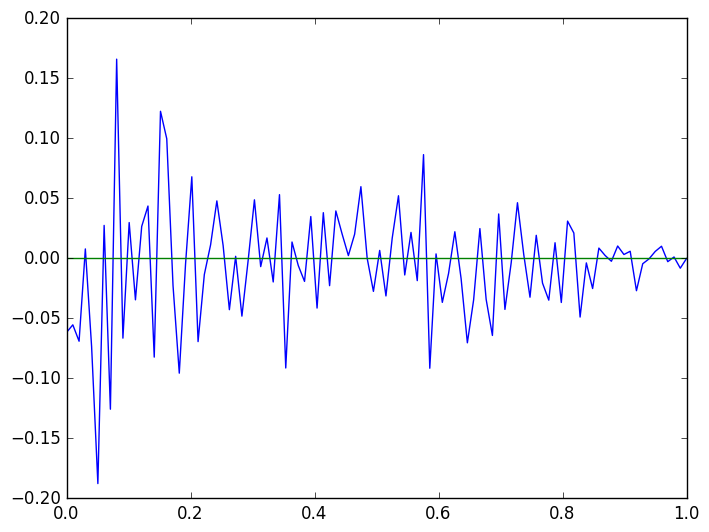

In [4]:
let t=linspace(0., 1., 100), s=50., p=GeometricBrownianMotion(.3, .4, s), portfolio = Stock()
    fn = t -> expectedFn(s -> payoff(portfolio, s), p, linspace(0,1-t,1000), 100000) * exp(-p.mu*(1-t))
    plot(t, fn.(t) - s)
    plot(t, zeros(t))
end;

## European Options

At-the-money:

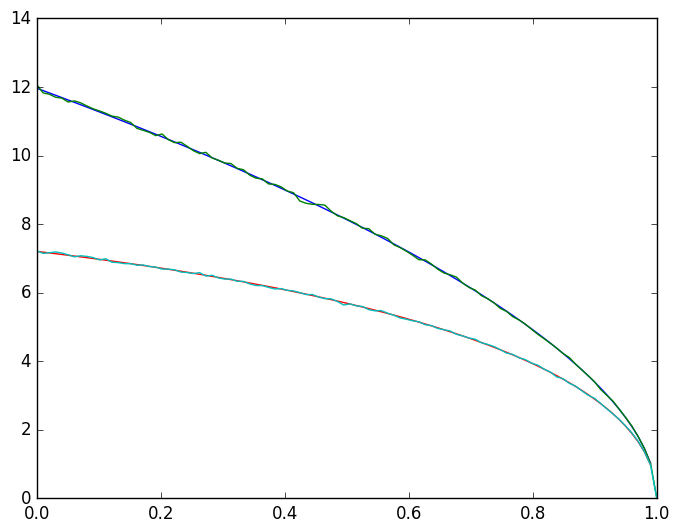

In [5]:
# todo: simplify, add scatter plot
let t=linspace(0., 1., 100), r=.1, k=50., s=k, p=GeometricBrownianMotion(r, .5, k), portfolio=EuropeanCall(k, 1.)
    plot(t, price(portfolio, t, s, r, p.sigma))
    fn = t -> mean(payoff(portfolio, rand(p, linspace(0,1-t,365), 100000))) * exp(-r*(1-t))
    plot(t, fn.(t))
end;
let t=linspace(0., 1., 100), r=.1, k=50., s=k, p=GeometricBrownianMotion(r, .5, k), portfolio=EuropeanPut(k, 1.)
    plot(t, price(portfolio, t, s, r, p.sigma))
    fn = t -> expectedFn(s -> payoff(portfolio, s), p, linspace(0,1-t,365), 100000) * exp(-r*(1-t))
    plot(t, fn.(t))
end;

At some fixed time:

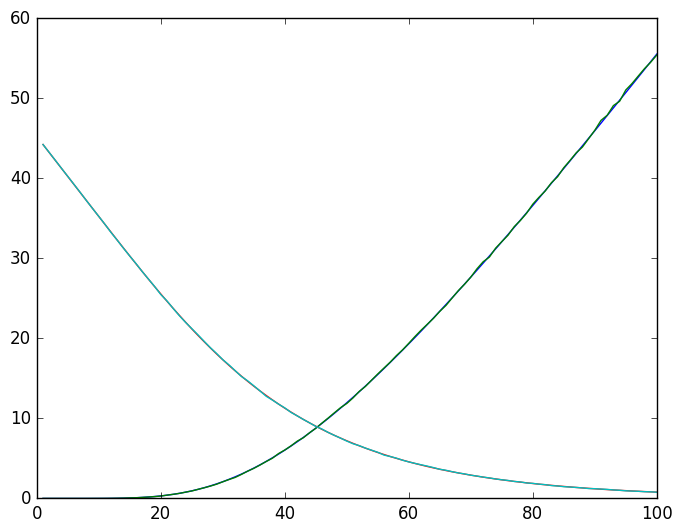

In [6]:
# todo: simplify, add scatter plot
let s=linspace(1, 100, 100), t=0, r=.1, k=50., sigma=.5, portfolio=EuropeanCall(k, 1.)
    plot(s, price(portfolio, 0, s, r, sigma))
    fn = s -> mean(payoff(portfolio, rand(GeometricBrownianMotion(r, sigma, s), linspace(0,1-t,365), 100000))) * exp(-r*(1-t))
    plot(s, fn.(s))
end;
let s=linspace(1, 100, 100), t=0, r=.1, k=50., sigma=.5, portfolio=EuropeanPut(k, 1.)
    plot(s, price(portfolio, 0, s, r, sigma))
    fn = s -> mean(payoff(portfolio, rand(GeometricBrownianMotion(r, sigma, s), linspace(0,1-t,365), 100000))) * exp(-r*(1-t))
    plot(s, fn.(s))
end;

## Binary Options

At-the-money:

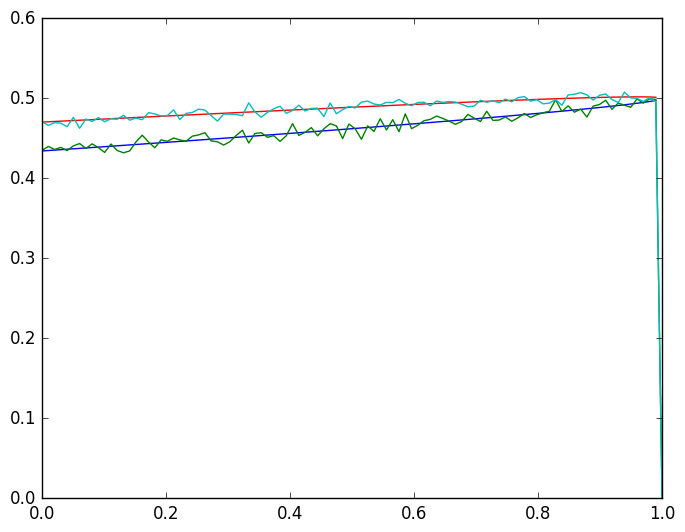

In [9]:
# todo: simplify, add scatter plot
# todo: strange behavior around 1
let t=linspace(0., 1., 100), r=.1, k=50., s=k, p=GeometricBrownianMotion(r, .5, k), portfolio=BinaryCall(k, 1.)
    plot(t, price(portfolio, t, s, r, p.sigma))
    fn = t -> mean(payoff(portfolio, rand(p, linspace(0,1-t,365), 10000))) * exp(-r*(1-t))
    plot(t, fn.(t))
end;
let t=linspace(0., 1., 100), r=.1, k=50., s=k, p=GeometricBrownianMotion(r, .5, k), portfolio=BinaryPut(k, 1.)
    plot(t, price(portfolio, t, s, r, p.sigma))
    fn = t -> expectedFn(s -> payoff(portfolio, s), p, linspace(0,1-t,365), 10000) * exp(-r*(1-t))
    plot(t, fn.(t))
end;

At fixed time:

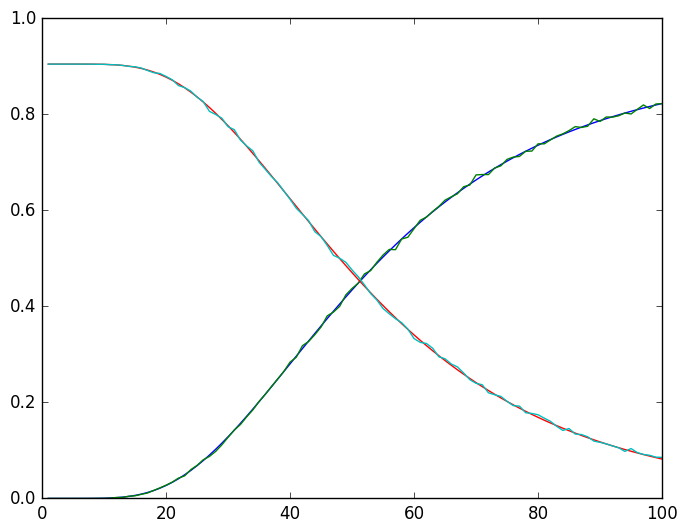

In [10]:
# todo: simplify, add scatter plot
let s=linspace(1, 100, 100), t=0, r=.1, k=50., sigma=.5, portfolio=BinaryCall(k, 1.)
    plot(s, price(portfolio, 0, s, r, sigma))
    fn = s -> mean(payoff(portfolio, rand(GeometricBrownianMotion(r, sigma, s), linspace(0,1-t,365), 10000))) * exp(-r*(1-t))
    plot(s, fn.(s))
end;
let s=linspace(1, 100, 100), t=0, r=.1, k=50., sigma=.5, portfolio=BinaryPut(k, 1.)
    plot(s, price(portfolio, 0, s, r, sigma))
    fn = s -> mean(payoff(portfolio, rand(GeometricBrownianMotion(r, sigma, s), linspace(0,1-t,365), 10000))) * exp(-r*(1-t))
    plot(s, fn.(s))
end;